#  Flight Delay Prediction

![flight*](https://github.com/frandiego/img/blob/master/flight.jpeg?raw=true)

In [0]:
!pip install pydot

In [0]:
import pandas as pd
from datetime import datetime
# from tools import *
from copy import  deepcopy
from plotnine import *
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")

In [0]:
#@hidden
import pydot   
from IPython.display import Image

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz

from copy import deepcopy

## classification importance with and ExtraTreesClassifier
def classification_feature_importance(X,
                                      y,
                                      n_estimators=100, 
                                      criterion='gini',
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      min_weight_fraction_leaf=0.,
                                      max_features='auto', 
                                      max_leaf_nodes=None,
                                      min_impurity_decrease=0.,
                                      min_impurity_split=1e-7, 
                                      bootstrap=True,
                                      oob_score=True,
                                      n_jobs=1, 
                                      random_state=0,
                                      verbose=0,
                                      class_weight=None):
    
    classifier = ExtraTreesClassifier(n_estimators=n_estimators, 
                                      criterion=criterion,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      min_weight_fraction_leaf=min_weight_fraction_leaf,
                                      max_features=max_features, 
                                      max_leaf_nodes=max_leaf_nodes,
                                      min_impurity_decrease=min_impurity_decrease,
                                      min_impurity_split=min_impurity_split, 
                                      bootstrap=bootstrap,
                                      oob_score=oob_score,
                                      n_jobs=n_jobs, 
                                      random_state=random_state,
                                      verbose=verbose,
                                      class_weight=class_weight)
    classifier.fit(X,y)
    df_importance = pd.DataFrame({'feature':list(X.columns),
                                  'importance':list(classifier.feature_importances_)})
    df_importance.sort_values('importance',inplace=True,ascending=False)
    return df_importance



## plot a tree
def plot_tree(estimator,features_names):
    dot_data = StringIO()  
    export_graphviz(estimator, 
                    out_file=dot_data,
                    feature_names=features_names,
                    filled=True,rounded=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph[0].create_png())  

## find correlations

def take_most_correlated(df,correlation_threshold = 0.9):
    aux = df.corr()[(df.corr()>=correlation_threshold)].reset_index().melt('index').dropna()
    aux = aux[aux['index'] != aux['variable']]
    aux['var_left'],aux['var_right'] = aux.apply(lambda r:sorted([r['index'],r['variable']]),axis=1).str
    aux = aux.loc[:,['var_left','var_right','value']].drop_duplicates()
    var_list = list(aux['var_left'].values) + list(aux['var_right'].values)
    return pd.Series(var_list).value_counts(normalize=True)



## map encoder
def map_encoder_categorical(x):
    set_ = sorted(set(x))
    range_ = list(range(1,len(set_)+1))
    return dict(zip(set_,range_))

def map_encoder_fit(df,categorical_features):
    return {i:map_encoder_categorical(df[i]) for i in categorical_features}

def map_encoder_transform(df,map_encoder):
    df_ = deepcopy(df) 
    for i in map_encoder.keys():
        map_encoder_variable = map_encoder[i]
        fill_ = int(max(map_encoder_variable.values()) + 1)
        df_[i] = df_[i].map(map_encoder_variable).fillna(fill_).astype(int)
    return df_

## onehot encoder
def onehot_encoder_fit(df,columns):
    dict_ = {}
    dict_['categorical_columns'] = columns
    dict_['output_columns'] = list(pd.get_dummies(data=df,columns=columns).columns)
    return dict_

def onehot_encoder_transform(df,onehot_encoder):
    df_ = deepcopy(df)
    df_ = pd.get_dummies(data=df_,columns=onehot_encoder['categorical_columns'])
    df_ = df_.loc[:,onehot_encoder['output_columns']].fillna(0)

In [0]:
path_train = "https://raw.githubusercontent.com/frandiego/data/master/flights_train_ordered.csv"
airports_path = "https://raw.githubusercontent.com/frandiego/data/master/airports.csv"
airtime_path = "https://raw.githubusercontent.com/frandiego/data/master/airtime.csv"

In [0]:
df = pd.read_csv(path_train)
airports = pd.read_csv(airports_path)
airtime = pd.read_csv(airtime_path)

In [0]:
airports.head()


,code,airport,city,state,country,latitude,longitude
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [0]:
df.head()

,flight_id,departure_ts,carrier,departure_airport,arrival_airport,distance,delayed_15_min
0,RHKSO07,2019-01-01 05:30:00,EV,OKC,ATL,761,0
1,QBRVY01,2019-01-01 05:35:00,EV,CLE,ATL,554,0
2,UIRQB06,2019-01-01 05:51:00,MQ,PIA,ORD,130,0
3,QLCPG01,2019-01-01 05:53:00,OO,AZO,ORD,122,0
4,FCEFR01,2019-01-01 05:53:00,MQ,MLI,ORD,139,0


In [0]:
airtime.head()

,departure_airport,arrival_airport,air_time
0,ABE,ATL,113.641509
1,ABE,DTW,85.000000
2,ABE,ORD,111.425532
3,ABI,DFW,38.892857
4,ABQ,ATL,158.272727


In [0]:
airports.rename(columns={"code": "departure_airport"}, inplace=True)
airports_df = pd.merge(df, airports, on='departure_airport', how='outer')
df = pd.merge(airports_df, airtime, on=['arrival_airport','departure_airport'], how='outer')
df.head()

,flight_id,departure_ts,carrier,departure_airport,arrival_airport,distance,delayed_15_min,airport,city,state,country,latitude,longitude,air_time
0,RHKSO07,2019-01-01 05:30:00,EV,OKC,ATL,761.0,0.0,Will Rogers World Airport,Oklahoma City,OK,USA,35.39309,-97.60073,109.2
1,TDBZI07,2019-01-09 14:05:00,EV,OKC,ATL,761.0,1.0,Will Rogers World Airport,Oklahoma City,OK,USA,35.39309,-97.60073,109.2
2,YAAQT02,2019-04-22 05:30:00,EV,OKC,ATL,761.0,0.0,Will Rogers World Airport,Oklahoma City,OK,USA,35.39309,-97.60073,109.2
3,PBUVX02,2019-06-04 17:51:00,DL,OKC,ATL,761.0,0.0,Will Rogers World Airport,Oklahoma City,OK,USA,35.39309,-97.60073,109.2
4,CHPOL06,2019-07-02 05:25:00,EV,OKC,ATL,761.0,0.0,Will Rogers World Airport,Oklahoma City,OK,USA,35.39309,-97.60073,109.2


In [0]:
df.isna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84416 entries, 0 to 84415
Data columns (total 14 columns):
flight_id            84416 non-null bool
departure_ts         84416 non-null bool
carrier              84416 non-null bool
departure_airport    84416 non-null bool
arrival_airport      84416 non-null bool
distance             84416 non-null bool
delayed_15_min       84416 non-null bool
airport              84416 non-null bool
city                 84416 non-null bool
state                84416 non-null bool
country              84416 non-null bool
latitude             84416 non-null bool
longitude            84416 non-null bool
air_time             84416 non-null bool
dtypes: bool(14)
memory usage: 1.8 MB


## Problem description
The data comes from a public dataset provided by **IATA** to generate AI models in the airline industry.

## Features
* **flight_id** : identificator of the flight
* **departure_ts** : timestamp with the departure time
* **carrier**: company that operates the flights
* **departure_airport** airport code
* **arrival_airport** airport code
* **distance** (in miles)
* **delayed_15_min** (1 or 0) **label**

#### airpots dataset
* **code** airport code
* **airport** airport name
* **city**
* **state** 
* **country** 
* **latitude**
* **longitude**

#### airtime dataset
* **departure_airport** airport code
* **arrival_airport** airport code
* **air_time** flying time in minutes

## 1. Feature Engineering

In [0]:
df['departure_ts'] = pd.to_datetime(df['departure_ts'])
df['day'] = df['departure_ts'].dt.day

In [0]:
df['air_time_in_h'] = df['air_time'] / 60
df['speed'] = df['distance'] / df['air_time_in_h']

## 2. Feature transformation. 
Apply those transformations you may think are relevant for the model to predict better. Wrap all these tranformations in a function to apply them easier to train and test data. 

One of the main transformation I've done is the map encoder, the result is [here](https://raw.githubusercontent.com/frandiego/auxiliar/master/map_encoder.json) and you can read it with the next function. (Again this is only an example)

In [0]:
import urllib.request, json
def read_json_to_dict(path):
    url = urllib.request.urlopen(path) 
    data = json.loads(url.read().decode())
    return data
path_map_encoder = "https://raw.githubusercontent.com/frandiego/auxiliar/master/map_encoder.json"
map_en = read_json_to_dict(path_map_encoder)
map_en

{'carrier': {'AA': 1,
  'AQ': 2,
  'AS': 3,
  'B6': 4,
  'CO': 5,
  'DH': 6,
  'DL': 7,
  'EV': 8,
  'F9': 9,
  'FL': 10,
  'HA': 11,
  'HP': 12,
  'MQ': 13,
  'NW': 14,
  'OH': 15,
  'OO': 16,
  'TZ': 17,
  'UA': 18,
  'US': 19,
  'WN': 20,
  'XE': 21,
  'YV': 22},
 'departure_airport': {'ABE': 1,
  'ABI': 2,
  'ABQ': 3,
  'ABY': 4,
  'ACK': 5,
  'ACT': 6,
  'ACV': 7,
  'ACY': 8,
  'ADQ': 9,
  'AEX': 10,
  'AGS': 11,
  'AKN': 12,
  'ALB': 13,
  'AMA': 14,
  'ANC': 15,
  'ASE': 16,
  'ATL': 17,
  'ATW': 18,
  'AUS': 19,
  'AVL': 20,
  'AVP': 21,
  'AZO': 22,
  'BDL': 23,
  'BET': 24,
  'BFL': 25,
  'BGM': 26,
  'BGR': 27,
  'BHM': 28,
  'BIL': 29,
  'BIS': 30,
  'BLI': 31,
  'BMI': 32,
  'BNA': 33,
  'BOI': 34,
  'BOS': 35,
  'BPT': 36,
  'BQK': 37,
  'BQN': 38,
  'BRO': 39,
  'BRW': 40,
  'BTM': 41,
  'BTR': 42,
  'BTV': 43,
  'BUF': 44,
  'BUR': 45,
  'BWI': 46,
  'BZN': 47,
  'CAE': 48,
  'CAK': 49,
  'CDC': 50,
  'CDV': 51,
  'CEC': 52,
  'CHA': 53,
  'CHO': 54,
  'CHS': 55,
  'CID

## 3. Data Visualization. 
Visualize the data the way you think is better to understand the nature of the data you have in hands. Use `plotnine` or not (I use it because I find it's the easier way to plot data)

In [0]:
category_columns = df.columns[(df.nunique()<=160)].tolist()
dfplot = df[category_columns].melt('delayed_15_min')
dfplot = dfplot.groupby(['variable','value']).agg(mean = ('delayed_15_min','mean')).reset_index()
dfplot = dfplot.groupby(['variable']).agg(std = ('mean','std')).reset_index()
dfplot = dfplot.sort_values('std')  
dfplot['variable'] = pd.Categorical(dfplot['variable'],categories=dfplot['variable'].unique())

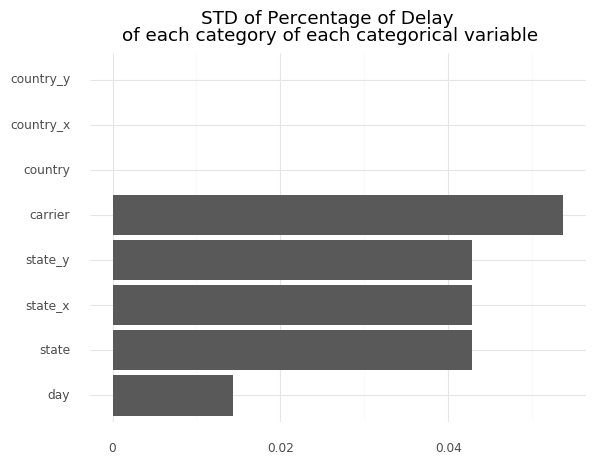

<ggplot: (-9223371951218308232)>

In [0]:
ggplot(dfplot,aes(x='variable',y='std')) +\
geom_col() + \
coord_flip() + \
theme_minimal()+\
labs(x='',y='',title='STD of Percentage of Delay \nof each category of each categorical variable')

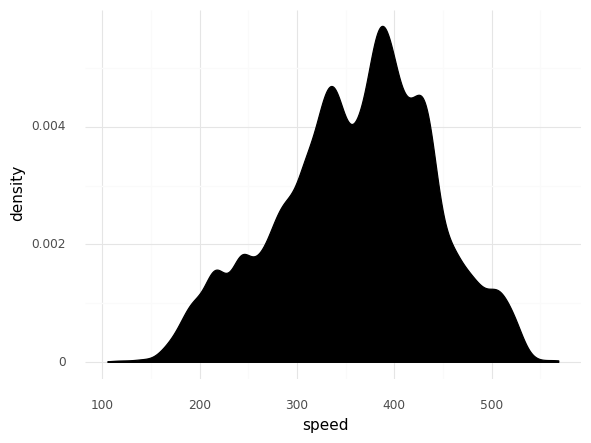

<ggplot: (-9223371951218245796)>

In [0]:
ggplot(df,aes(x='speed')) + \
geom_density(fill='black')  + theme_minimal()

## 4. Model.
* Craft a ML model to classify the label `delayed_15_min` (1/0) 
* Select the variables you consider most important. 
* Tune your model (automatically or manually) to improve the model avoiding overfitting. 

***
* You can find a version of X (clean) in the next urls. (Again, this is just an example, you can do it much better)

```python
"https://raw.githubusercontent.com/frandiego/auxiliar/master/flights_train_clean_version.csv"
"https://raw.githubusercontent.com/frandiego/auxiliar/master/flights_test_clean_version.csv"  
```

In [0]:
X_train = pd.read_csv("https://raw.githubusercontent.com/frandiego/auxiliar/master/flights_train_clean_version.csv")
X_test = pd.read_csv("https://raw.githubusercontent.com/frandiego/auxiliar/master/flights_test_clean_version.csv")

In [0]:
y_train = pd.read_csv("https://raw.githubusercontent.com/frandiego/data/master/flights_train_ordered.csv")['delayed_15_min']
y_test = pd.read_csv("https://raw.githubusercontent.com/frandiego/data/master/flights_test_ordered.csv")['delayed_15_min']

In [0]:
X_train.head()

,carrier,departure_airport,arrival_airport,distance,month,day,isoweekday,hour,air_time,speed,departure_state,arrival_state
0,8,186,17,1224.70774,1,1,2,5,109.200000,672.916341,36,10
1,8,58,17,891.57436,1,1,2,5,98.568966,542.710998,35,10
2,13,198,190,209.21420,1,1,2,5,38.823529,323.331036,14,14
3,16,22,190,196.33948,1,1,2,5,37.962963,310.312154,22,14
4,13,172,190,223.69826,1,1,2,5,39.571429,339.181477,14,14


In [0]:
y_train.head()

,flight_id,departure_ts,carrier,departure_airport,arrival_airport,distance,delayed_15_min
0,RHKSO07,2019-01-01 05:30:00,EV,OKC,ATL,761,0
1,QBRVY01,2019-01-01 05:35:00,EV,CLE,ATL,554,0
2,UIRQB06,2019-01-01 05:51:00,MQ,PIA,ORD,130,0
3,QLCPG01,2019-01-01 05:53:00,OO,AZO,ORD,122,0
4,FCEFR01,2019-01-01 05:53:00,MQ,MLI,ORD,139,0


In [0]:
from lightgbm import LGBMClassifier
import numpy as np
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import *
def metrics_clf(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('AUC    : ', np.round(roc_auc_score(y_test,y_pred),3))
    print('Kappa  : ', np.round(cohen_kappa_score(y_test,y_pred),3))
    print(classification_report(y_test,y_pred))
    return model

In [0]:
from sklearn.feature_selection import RFE
rfe = RFE(LGBMClassifier(random_state=101),n_features_to_select=5)

In [0]:
rfe.fit(X_train,y_train)

RFE(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                             colsample_bytree=1.0, importance_type='split',
                             learning_rate=0.1, max_depth=-1,
                             min_child_samples=20, min_child_weight=0.001,
                             min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                             num_leaves=31, objective=None, random_state=101,
                             reg_alpha=0.0, reg_lambda=0.0, silent=True,
                             subsample=1.0, subsample_for_bin=200000,
                             subsample_freq=0),
    n_features_to_select=5, step=1, verbose=0)

In [0]:
list(X_train.columns[rfe.support_])

['departure_airport', 'arrival_airport', 'hour', 'air_time', 'speed']

In [0]:
y_pred_rfe = rfe.predict(X_test)

## 5. Evaluation

In [0]:
metrics_clf(LGBMClassifier(random_state=101))

AUC    :  0.532
Kappa  :  0.095
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     13001
           1       0.70      0.07      0.13      3373

    accuracy                           0.80     16374
   macro avg       0.75      0.53      0.51     16374
weighted avg       0.78      0.80      0.73     16374



LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

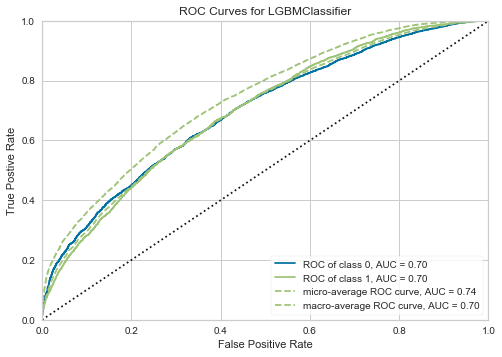

In [0]:
model = LGBMClassifier(class_weight='balanced',random_state=101)
visualizer = ROCAUC(model, classes=[0,1])
visualizer.fit(X_train, y_train)     
visualizer.score(X_test, y_test)    
visualizer.show() 

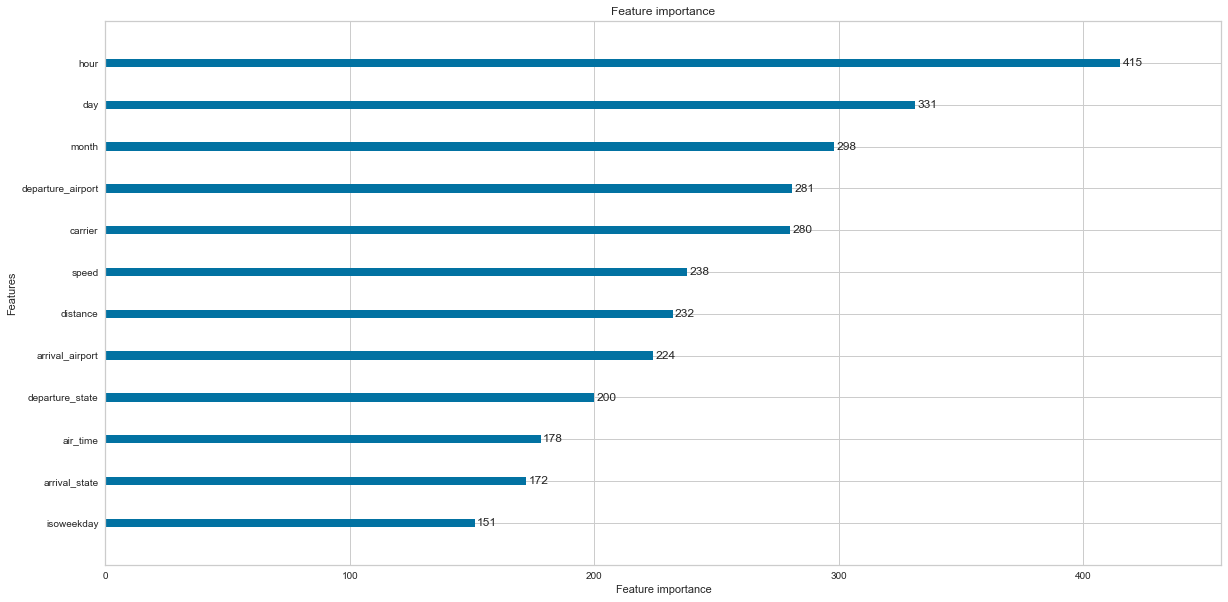

In [0]:
from lightgbm import plot_importance
plot_importance(model.booster_,figsize=(20,10))

## Evaluation
* I decided to include all the variables in LightGBM model, as we can see on the graph of feature importance --> most of those have similar importance.
* Accuracy of the model is 0.80, which means that most of the times model is correct.
* We could improve it by using several algorithms (maybe AdaBoost, CatBoost etc) to compare the metrics. 
* ROC curve (0.70) summarizes the performance of a classifier over all possible thresholds. 
* Precision is also quite good(0.80), which means that in 80% of the times when model predicts yes - it is actually correct